In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2023-04-02 16:24:02.182742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
train_df = pd.read_csv('../data/ex_train.csv')
val_df = pd.read_csv('../data/ex_val.csv')
test_df = pd.read_csv('../data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [5]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [6]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Chapter 13 

## Single-step
### Baseline

In [7]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [8]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [9]:
baseline_last = Baseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

2023-04-02 16:24:04.472809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

119/119 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0287


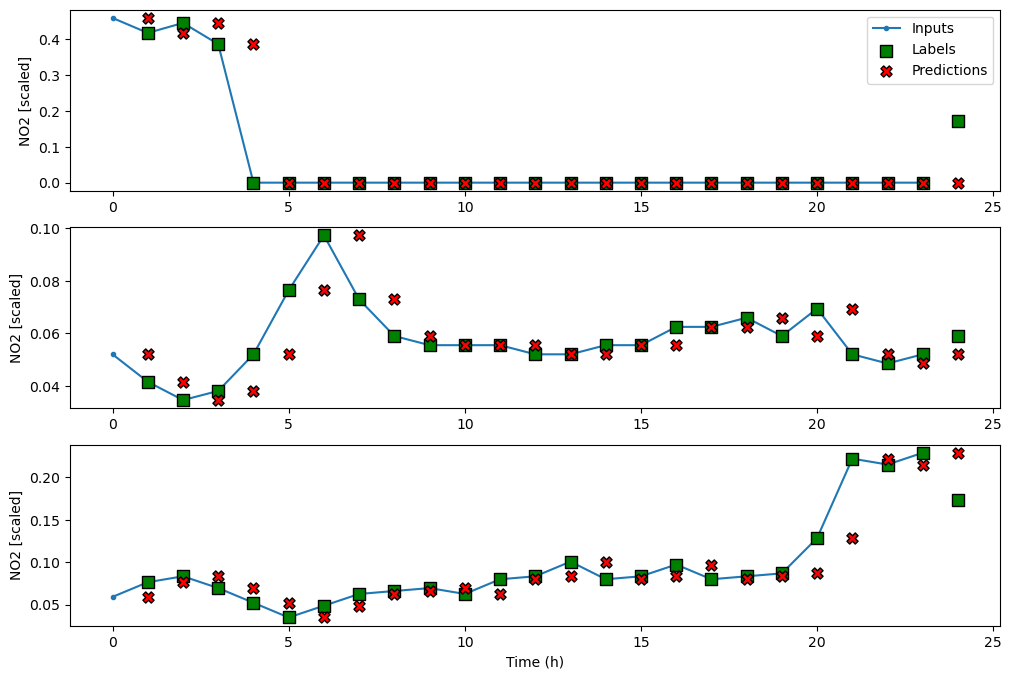

In [11]:
wide_window.plot(baseline_last)

## Multi-step
### Baseline

#### Repeast last value 

In [12]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [13]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [14]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 2ms/step - loss: 0.1443 - mean_absolute_error: 0.2821


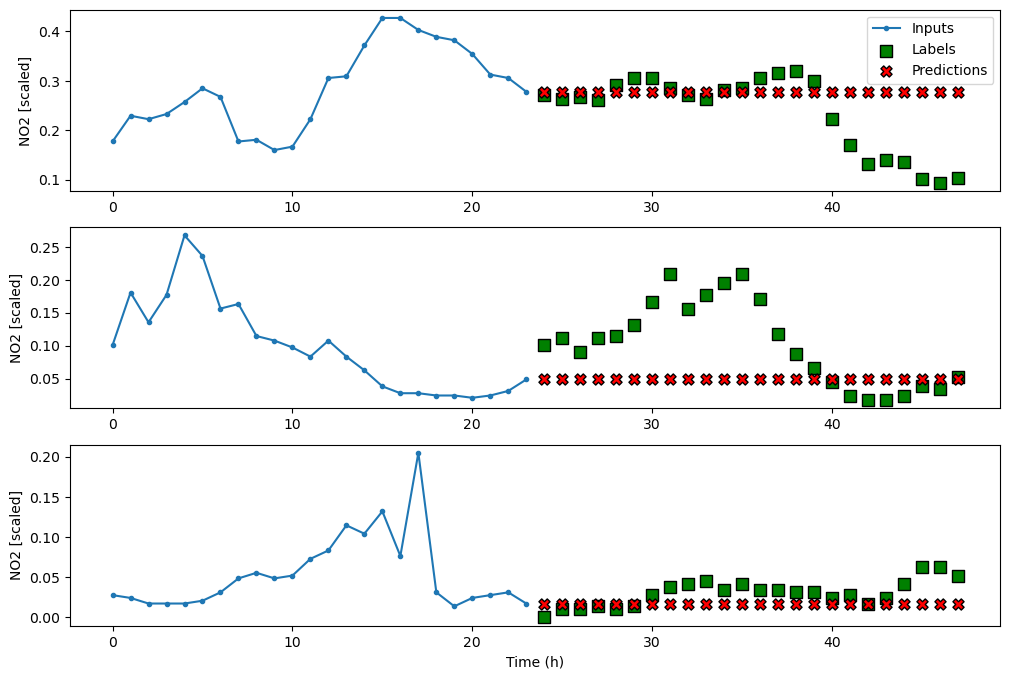

In [15]:
multi_window.plot(ms_baseline_last)

#### Repeat last season 

In [16]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [17]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['NO2'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 2ms/step - loss: 0.1426 - mean_absolute_error: 0.2818


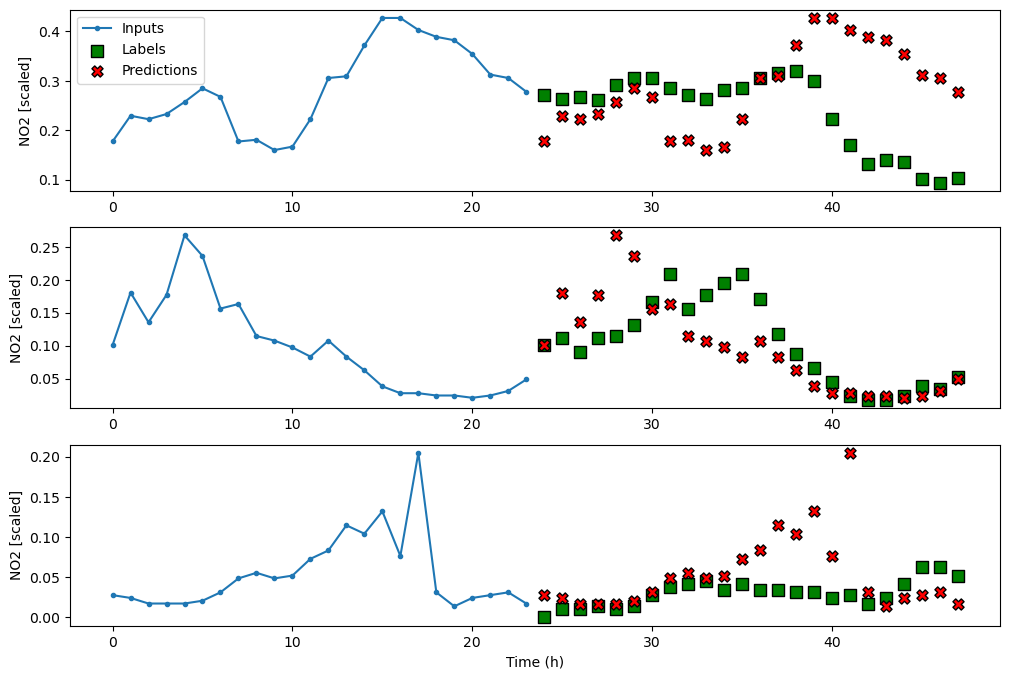

In [18]:
multi_window.plot(ms_baseline_repeat)

## Multi-output
### Baseline

In [19]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])

In [20]:
print(column_indices['NO2'])
print(column_indices['TEMP'])

3
6


In [21]:
mo_baseline_last = Baseline(label_index=[3, 6])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0215


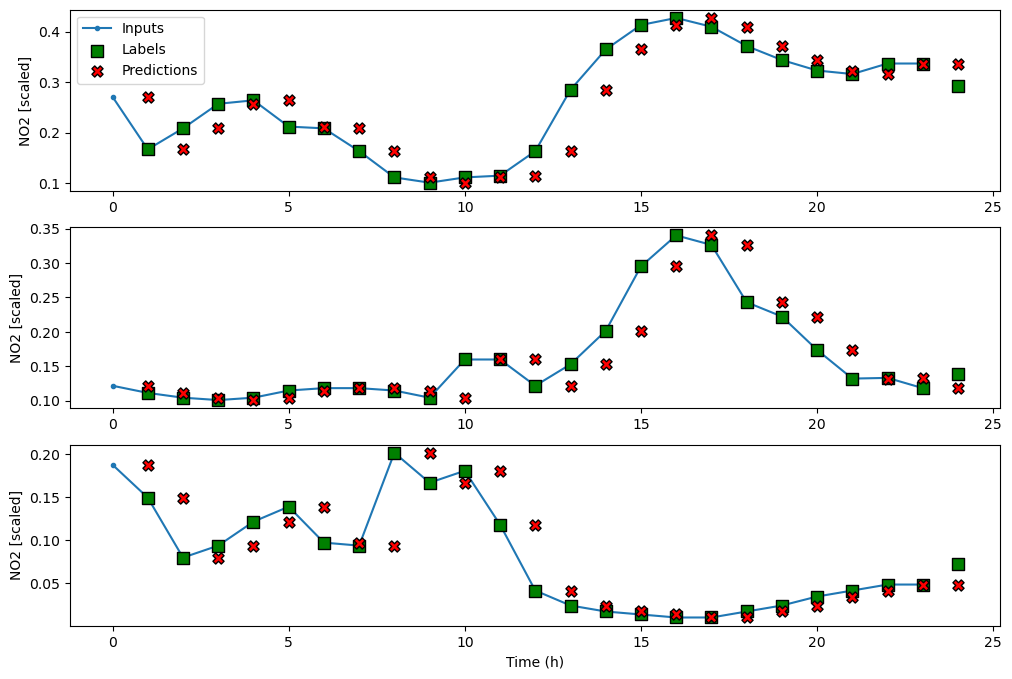

In [22]:
mo_wide_window.plot(mo_baseline_last)

# Chapter 14 

In [23]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

## Single-step 

### Linear model 

In [24]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.1108 - mean_absolute_error: 0.2528 - val_loss: 0.0298 - val_mean_absolute_error: 0.1435
Epoch 2/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0258 - mean_absolute_error: 0.1303 - val_loss: 0.0151 - val_mean_absolute_error: 0.1005
Epoch 3/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0127 - mean_absolute_error: 0.0894 - val_loss: 0.0068 - val_mean_absolute_error: 0.0652
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0596 - val_loss: 0.0035 - val_mean_absolute_error: 0.0434
Epoch 5/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0432 - val_loss: 0.0025 - val_mean_absolute_error: 0.0347
Epoch 6/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0357 - val_loss: 0.0022 - val_mean_absolute_error: 0.0317
Epoch 7/50
414/4

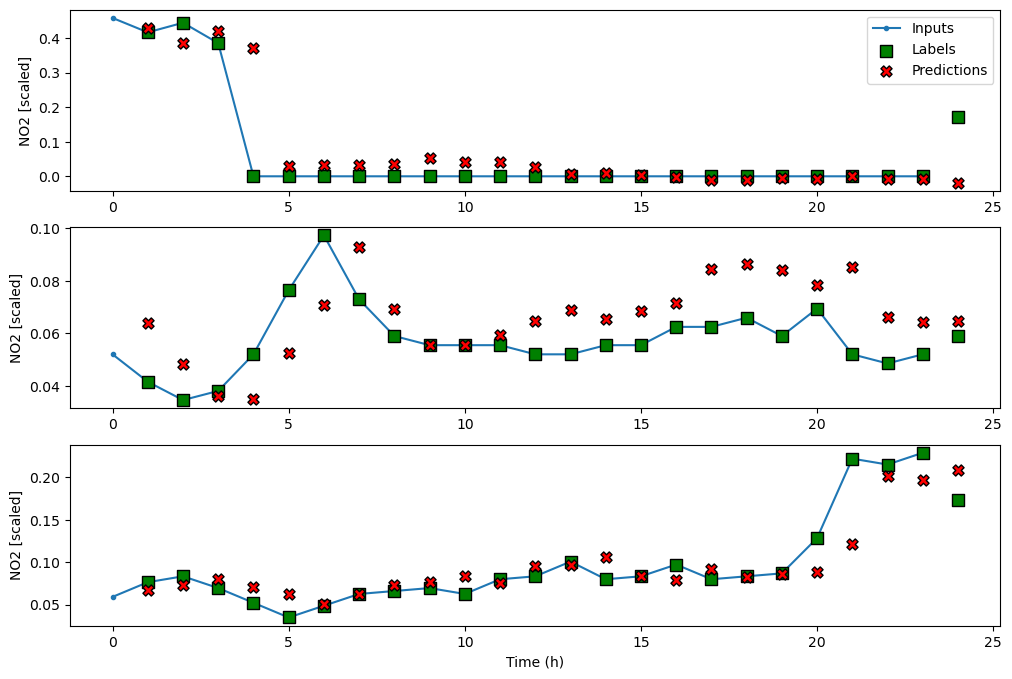

In [25]:
wide_window.plot(linear)

### Dense model (DNN) 

In [26]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0354 - val_loss: 0.0020 - val_mean_absolute_error: 0.0295
Epoch 2/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0274 - val_loss: 0.0020 - val_mean_absolute_error: 0.0293
Epoch 3/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0278 - val_loss: 0.0020 - val_mean_absolute_error: 0.0290
Epoch 4/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0267 - val_loss: 0.0019 - val_mean_absolute_error: 0.0280
Epoch 5/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0266 - val_loss: 0.0019 - val_mean_absolute_error: 0.0279
Epoch 6/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0268 - val_loss: 0.0019 - val_mean_absolute_error: 0.0276
Epoch 7/50
414/4

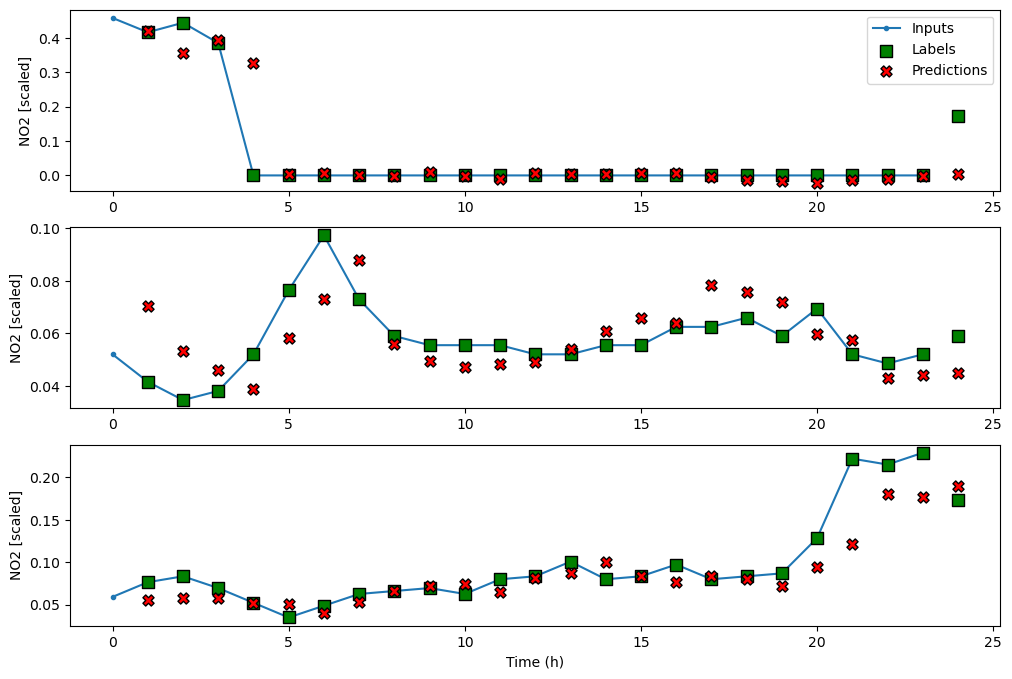

In [27]:
wide_window.plot(dense)

### Evaluation 

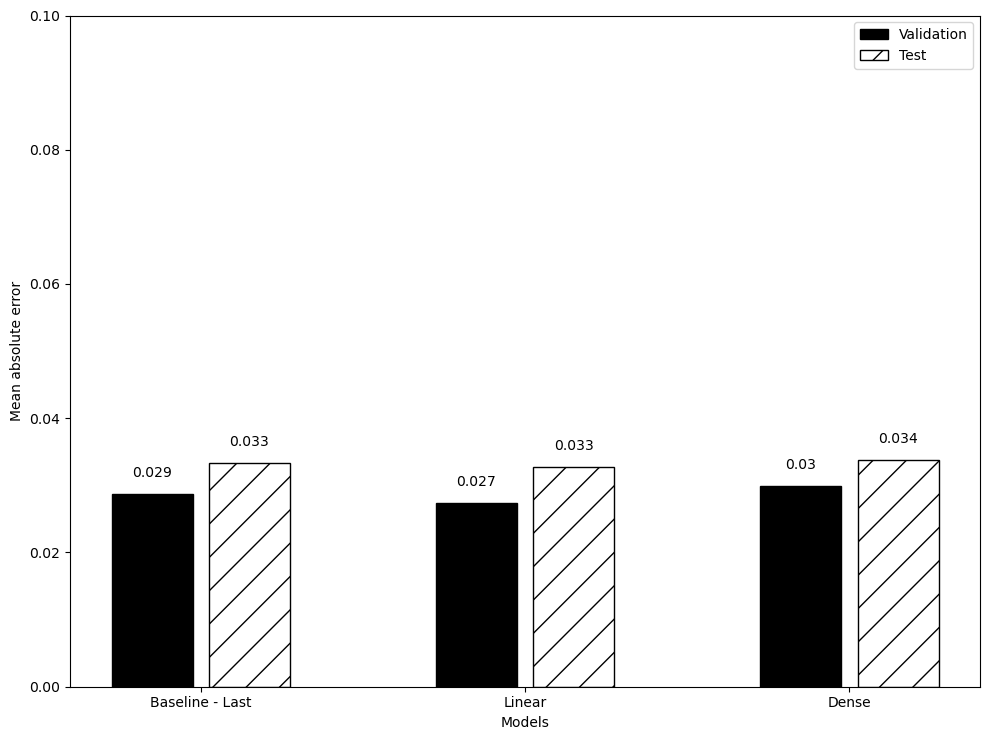

In [28]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-step 

### Linear model 

In [29]:
label_index = column_indices['NO2']
num_features = train_df.shape[1]

ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0930 - val_loss: 0.0095 - val_mean_absolute_error: 0.0736
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0847 - val_loss: 0.0091 - val_mean_absolute_error: 0.0717
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0120 - mean_absolute_error: 0.0835 - val_loss: 0.0089 - val_mean_absolute_error: 0.0709
Epoch 4/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0118 - mean_absolute_error: 0.0827 - val_loss: 0.0088 - val_mean_absolute_error: 0.0703
Epoch 5/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0117 - mean_absolute_error: 0.0822 - val_loss: 0.0087 - val_mean_absolute_error: 0.0706
Epoch 6/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0116 - mean_absolute_error: 0.0819 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 7/50
413/4

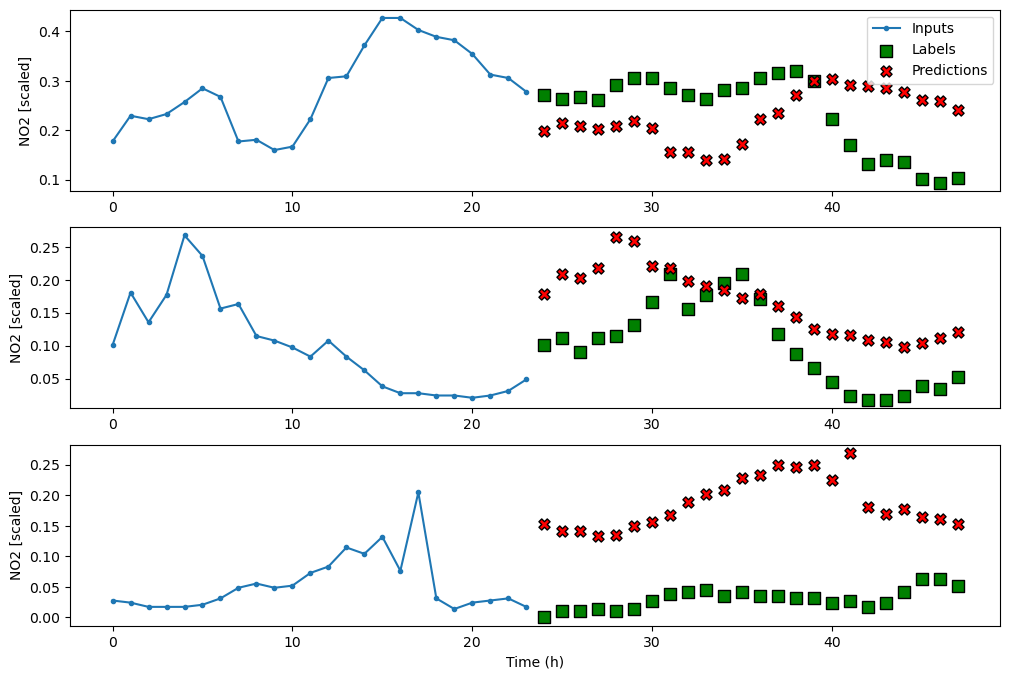

In [30]:
multi_window.plot(ms_linear)

### Dense model (DNN)

In [31]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 3s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0858 - val_loss: 0.0091 - val_mean_absolute_error: 0.0695
Epoch 2/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0110 - mean_absolute_error: 0.0794 - val_loss: 0.0084 - val_mean_absolute_error: 0.0681
Epoch 3/50
413/413 [==============================] - 2s 4ms/step - loss: 0.0108 - mean_absolute_error: 0.0786 - val_loss: 0.0085 - val_mean_absolute_error: 0.0686
Epoch 4/50
413/413 [==============================] - 2s 4ms/step - loss: 0.0107 - mean_absolute_error: 0.0780 - val_loss: 0.0097 - val_mean_absolute_error: 0.0720
Epoch 5/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0701


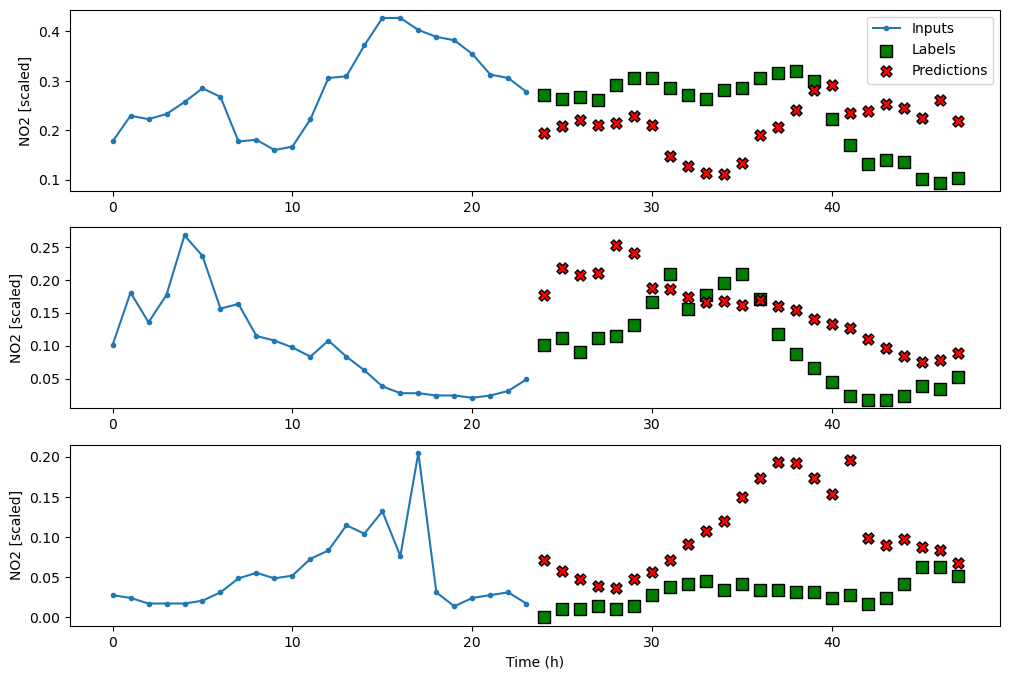

In [32]:
multi_window.plot(ms_dense)

### Evaluation

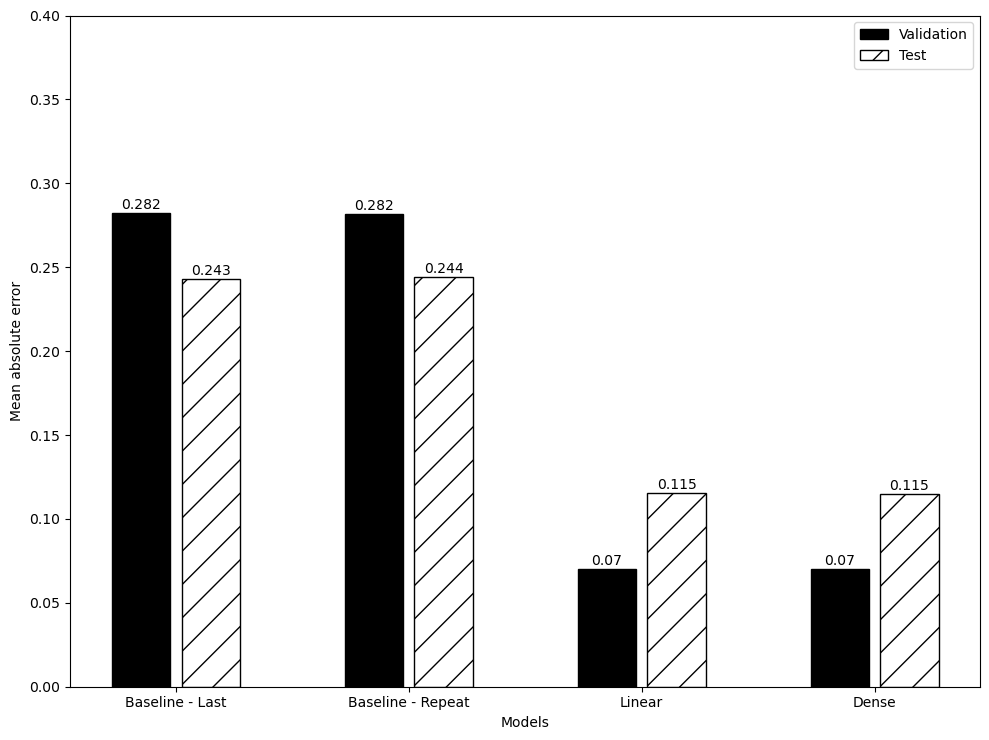

In [33]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-output 

### Linear model 

In [34]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.0707 - mean_absolute_error: 0.2073 - val_loss: 0.0334 - val_mean_absolute_error: 0.1444
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0169 - mean_absolute_error: 0.0999 - val_loss: 0.0079 - val_mean_absolute_error: 0.0701
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0049 - mean_absolute_error: 0.0531 - val_loss: 0.0029 - val_mean_absolute_error: 0.0416
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0376 - val_loss: 0.0019 - val_mean_absolute_error: 0.0327
Epoch 5/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0323 - val_loss: 0.0017 - val_mean_absolute_error: 0.0295
Epoch 6/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0294 - val_loss: 0.0015 - val_mean_absolute_error: 0.0270
Epoch 7/50
414/4

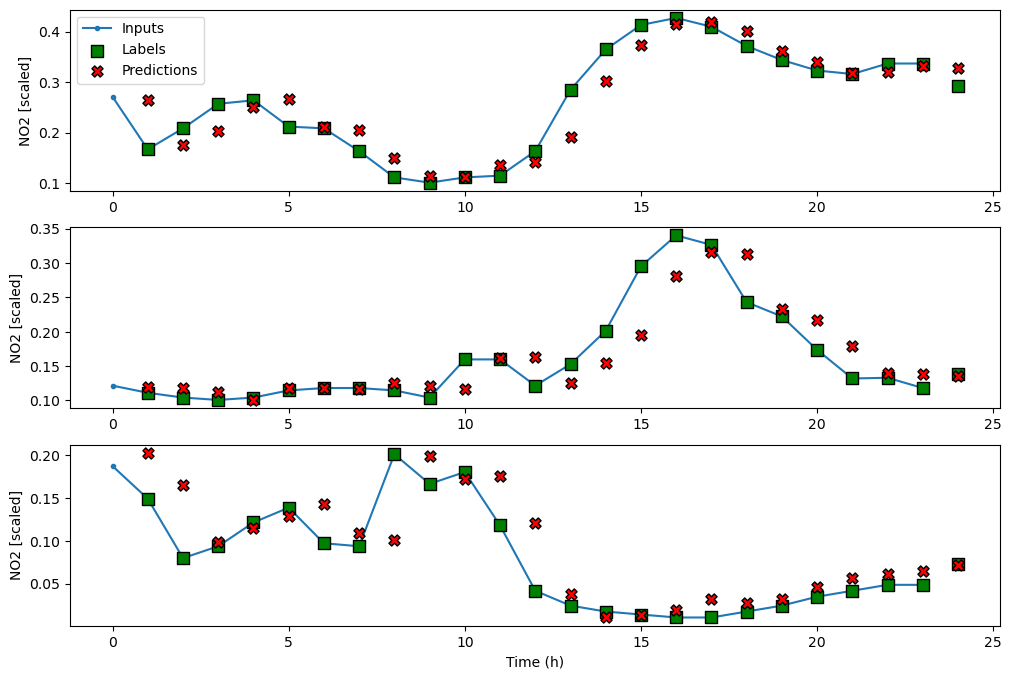

In [35]:
mo_wide_window.plot(mo_linear)

### Dense model (DNN) 

In [36]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 3s 5ms/step - loss: 0.0061 - mean_absolute_error: 0.0433 - val_loss: 0.0014 - val_mean_absolute_error: 0.0251
Epoch 2/50
414/414 [==============================] - 2s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0223 - val_loss: 0.0013 - val_mean_absolute_error: 0.0229
Epoch 3/50
414/414 [==============================] - 2s 5ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0012 - val_mean_absolute_error: 0.0223
Epoch 4/50
414/414 [==============================] - 2s 5ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0012 - val_mean_absolute_error: 0.0217
Epoch 5/50
414/414 [==============================] - 2s 5ms/step - loss: 9.9158e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0011 - val_mean_absolute_error: 0.0207
Epoch 6/50
414/414 [==============================] - 2s 5ms/step - loss: 0.0010 - mean_absolute_error: 0.0209 - val_loss: 0.0012 - val_mean_absolute_error: 0.0219
Epoch 7/50
4

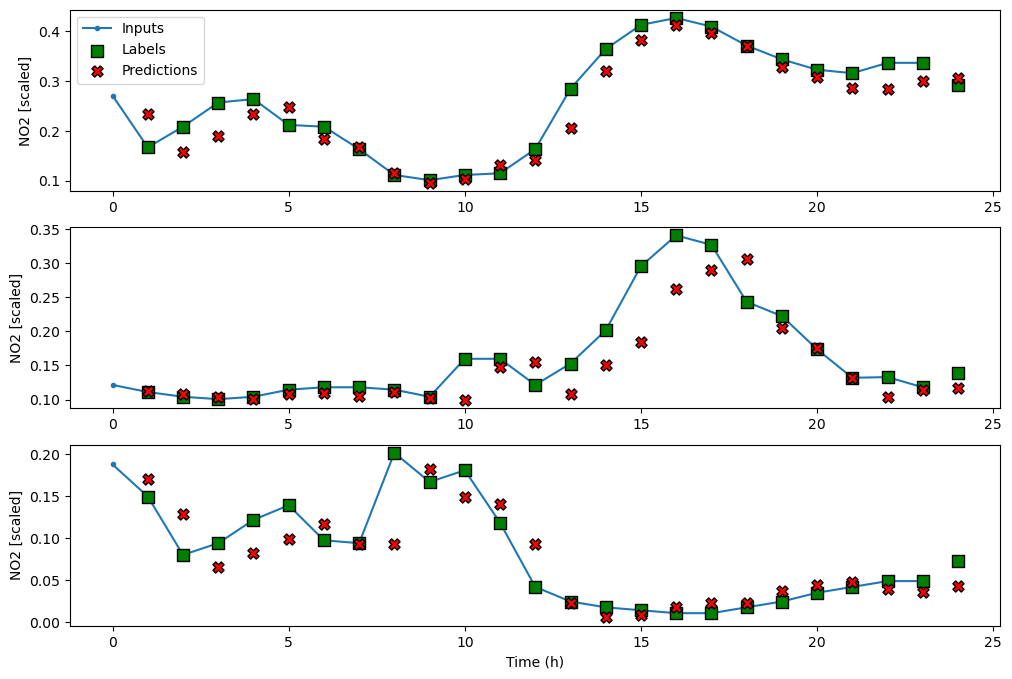

In [37]:
mo_wide_window.plot(mo_dense)

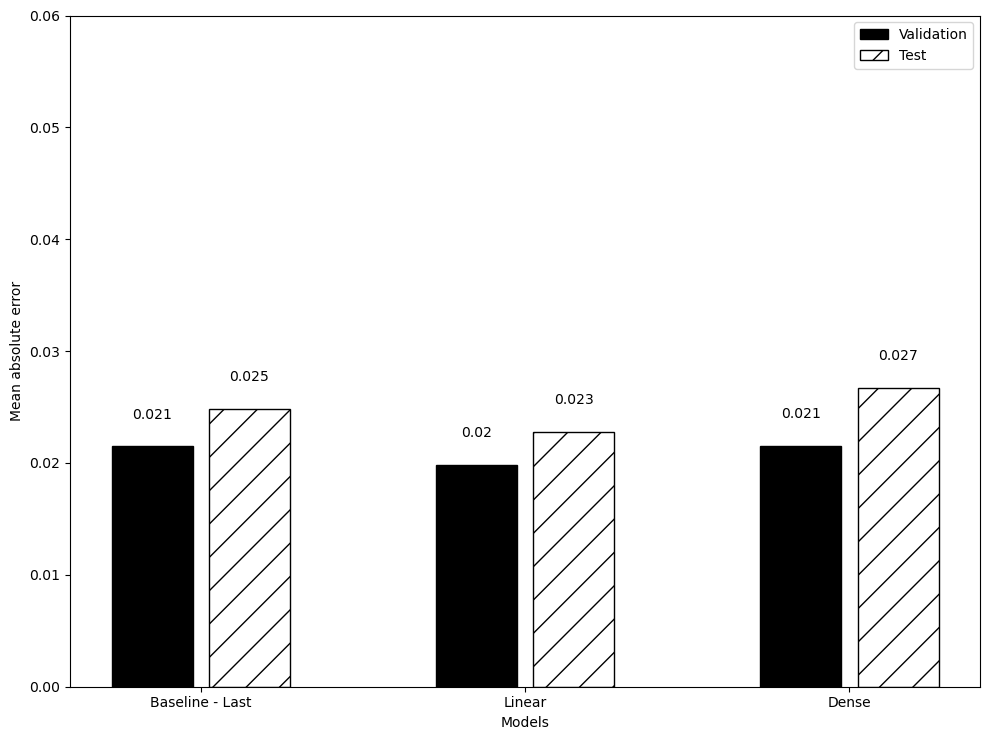

In [38]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()